<font color='red'><h1><center>---FINAL---</center></h1></font>

The final.ipynb contains the pipeline of the whole modelling process starting from taking data input and giving predictions as an output. The whole pipeline is designed in a way as if it is going to be used in deployed in production and hence it contains all the processess. They are in the following order:
> 1. Taking data as input
2. Imputation of missing values
3. Normalizing the data
4. Making Predictions
5. Calculating the performance metrics based on the predictions and actual value if evaluation of the model is to be done or just returning the predictions.

This notebook will contain two functions, the first one will be returning the predicitons whereas the second one will evaluate the model and print performance metrics.

### A small note:
The best imputation technique choosen at the end of the complete analysis was the MICE imputation method. However, it is a very complex (relatively) technique hence it takes a lot of space and has a high time complexity. Due to the constraints of the problem statement and the server, it is not possible to deploy a model with the mice impuation methodology. As a result, a different set of models was made by using the median imputation technique and were tuned to achieve nearly similar performance. 

Therefore, this notebook contains two different sets of final functions based on the type of imputation used.
The first set will contain the functions using the mice imputation technique and the second set will have functions implemented using the median imputation technique.

In [4]:
# importing libraries
import numpy as np
import joblib
import pandas as pd
from sklearn.metrics import f1_score
from metric_functions import misclassification_score, plot_matrices

# Set - 1 - MICE Imputation technique

## Function - 1

In [1]:
def final1(x):
    '''
        This function takes a datapoint(s) as input, preprocessess it and then predicts and returns the class label(s).
        NOTE: An assumption has been made that the input is the row or rows of a DataFrame with the same feature names and
        the same ordering in the features as the training dataset.
    '''
    
    # if the input is a single row, making it a DataFrame with the given columns
    if x.ndim == 1:   
        cols = joblib.load('Saves\\columns.pkl')
        x = pd.DataFrame(x.values.reshape(1,-1), columns=cols)
    
    # loading the imputation models and the imputation strategy list
    strat_list = joblib.load('Saves\\Impute\\strat_list.pickle')
    mice_imp = joblib.load('Saves\\Impute\\MICE\\mice_BayesianRidge.pickle')
    mean_imp = joblib.load('Saves\\Impute\\Means\\mean_imputer.pickle')
    median_imp = joblib.load('Saves\\Impute\\Medians\\median_imputer.pickle')
    # turning mice imputer verbose off
    mice_imp.verbose=0
    
    # performing missing value imputation
    # dropping the features with high missing values
    inter_ = x.drop(columns=strat_list[3])
    
    # mean imputation
    mean_imp = mean_imp.transform(inter_[strat_list[0]])
    inter_[strat_list[0]] = mean_imp
    
    # median imputation
    median_imputed = median_imp.transform(inter_[strat_list[1]])
    inter_[strat_list[1]] = median_imputed
    
    # mice imputation
    data = pd.DataFrame(mice_imp.transform(inter_), columns=inter_.columns)
    
    
    # scaling the data
    # loading the dictionary
    feature_limits = joblib.load('Saves\\Normalize values\\mice_norm_stock_limits.pickle')
    normalized = np.zeros(data.shape)
    
    # performing normalization
    for ind, feature in enumerate(data.columns):
        # get the feature values
        values = data[feature]
        # get the normalization limits
        limits = feature_limits[ind]
        # if the minimum and maximum levels are equal, we are going to change all values to 0
        if limits[0] == limits[1]:
            normed = np.zeros(data.shape[0])
            normalized[:,ind] = normed
        # else normalize
        normed = (values-limits[0])/(limits[1]-limits[0])
        normalized[:,ind] = normed
    
    # loading the model and the optimal threshold and predicting
    predictors = joblib.load('Saves\\ML\\best_xgb_model_mice.pkl')
    model = predictors['model']
    threshold = predictors['threshold']
    
    # making the predictions
    # getting probabilities
    probas = model.predict_proba(normalized)[:,1]
    
    # making predictions
    preds = [1 if p>0.2 else 0 for p in probas]
    
    return preds

# Function - 2

In [2]:
def final2(data, labels):
    '''
        This functions takes the raw data and the actual class labels and returns the performance metrics of the model.
        The performance metrics will be:
        Macro f1 score
        Confusion, recall and precision matrices
        Misclassification score
    '''
    # loading the imputation models and the imputation strategy list
    strat_list = joblib.load('Saves\\Impute\\strat_list.pickle')
    mice_imp = joblib.load('Saves\\Impute\\MICE\\mice_BayesianRidge.pickle')
    mean_imp = joblib.load('Saves\\Impute\\Means\\mean_imputer.pickle')
    median_imp = joblib.load('Saves\\Impute\\Medians\\median_imputer.pickle')
    # turning mice imputer verbose off
    mice_imp.verbose=0
    
    # performing missing value imputation
    # dropping the features with high missing values
    inter_ = data.drop(columns=strat_list[3])
    
    # mean imputation
    mean_imp = mean_imp.transform(inter_[strat_list[0]])
    inter_[strat_list[0]] = mean_imp
    
    # median imputation
    median_imputed = median_imp.transform(inter_[strat_list[1]])
    inter_[strat_list[1]] = median_imputed
    
    # mice imputation
    data = pd.DataFrame(mice_imp.transform(inter_), columns=inter_.columns)
    
    
    # scaling the data
    # loading the dictionary
    feature_limits = joblib.load('Saves\\Normalize values\\mice_norm_stock_limits.pickle')
    normalized = np.zeros(data.shape)
    
    # performing normalization
    for ind, feature in enumerate(data.columns):
        # get the feature values
        values = data[feature]
        # get the normalization limits
        limits = feature_limits[ind]
        # if the minimum and maximum levels are equal, we are going to change all values to 0
        if limits[0] == limits[1]:
            normed = np.zeros(data.shape[0])
            normalized[:,ind] = normed
        # else normalize
        normed = (values-limits[0])/(limits[1]-limits[0])
        normalized[:,ind] = normed
    
    # loading the model and the optimal threshold and predicting
    predictors = joblib.load('Saves\\ML\\best_xgb_model_mice.pkl')
    model = predictors['model']
    
    # making the predictions
    # getting probabilities
    probas = model.predict_proba(normalized)[:,1]
    
    # making predictions
    preds = ['pos' if p>0.2 else 'neg' for p in probas]
    
    # calculating the metrics
    f1 = f1_score(labels, preds, average='macro')
    cost = misclassification_score(labels, preds)
    
    # plotting the confusion matrices
    plot_matrices(labels, preds)
    print('Misclassification Cost:', cost, '\tF-1 Score:', f1)

## Testing both the functions

In [5]:
test = pd.read_csv('Data\\testset.csv', na_values='na')
X = test.drop(columns='class')
Y = test['class']

In [6]:
# function 1
preds = final1(X.iloc[:20])

In [7]:
print(*preds, sep=',')

0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


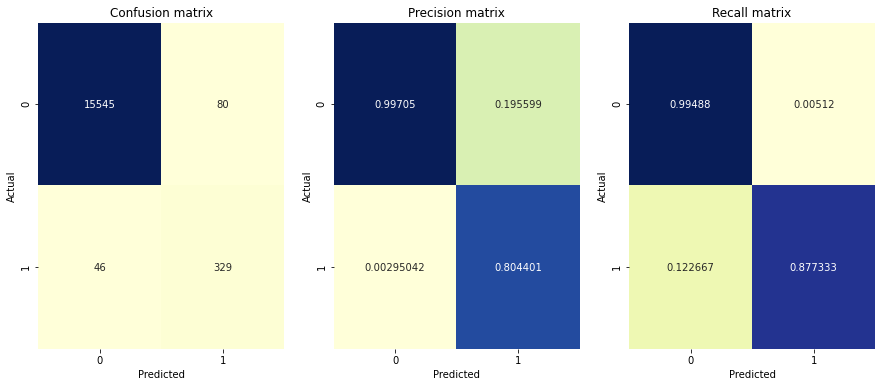

Misclassification Cost: 23800 	F-1 Score: 0.9176246613458299


In [8]:
# function 2
final2(X, Y)

# Set - 2 - Median Imputation

## final1

In [15]:
def final1(x):
    '''
        This function takes a datapoint(s) as input, preprocessess it and then predicts and returns the class label(s).
        NOTE: An assumption has been made that the input is the row or rows of a DataFrame with the same feature names and
        the same ordering in the features as the training dataset.
    '''
    
    # if the input is a single row, making it a DataFrame with the given columns
    if x.ndim == 1:   
        cols = joblib.load('Saves\\columns.pkl')
        x = pd.DataFrame(x.values.reshape(1,-1), columns=cols)
    
    # loading the imputation models and the imputation strategy list
    strat_list = joblib.load('Saves\\Impute\\strat_list.pickle')
    imputer = joblib.load('Saves\\Impute\\simpleImputer.pkl')

    # performing missing value imputation
    # dropping the features with high missing values
    inter_ = x.drop(columns=strat_list[3])
    # dropping the missing feature
    inter_ = inter_.drop(columns=['cd_000'])
    
    # imputation
    data = pd.DataFrame(imputer.transform(inter_), columns=inter_.columns)
    
    # scaling the data
    # loading the dictionary
    normalizer = joblib.load('Saves\\Normalize values\\minmaxScaler.pkl')
    # normalizing
    data_norm = normalizer.transform(data)
    
    # loading the model and the optimal threshold and predicting
    predictors = joblib.load('Saves\\ML\\SimpleImputer models\\xgb_clf_49_77.pkl')
    model = predictors['model']
    threshold = predictors['threshold']
    
    # making the predictions
    # getting probabilities
    probas = model.predict_proba(data_norm)[:,1]
    
    # making predictions
    preds = [1 if p>0.2 else 0 for p in probas]
    
    return preds

In [16]:
def final2(data, labels):
    '''
        This functions takes the raw data and the actual class labels and returns the performance metrics of the model.
        The performance metrics will be:
        Macro f1 score
        Confusion, recall and precision matrices
        Misclassification score
    '''
    # loading the imputation models and the imputation strategy list
    strat_list = joblib.load('Saves\\Impute\\strat_list.pickle')
    imputer = joblib.load('Saves\\Impute\\simpleImputer.pkl')
    
    # performing missing value imputation
    # dropping the features with high missing values
    inter_ = data.drop(columns=strat_list[3])
    # dropping the missing feature
    inter_ = inter_.drop(columns=['cd_000'])
    
    # imputation
    data = pd.DataFrame(imputer.transform(inter_), columns=inter_.columns)
    
    # scaling the data
    # loading the dictionary
    normalizer = joblib.load('Saves\\Normalize values\\minmaxScaler.pkl')
    # normalizing
    data_norm = normalizer.transform(data)
    
    # loading the model and the optimal threshold and predicting
    predictors = joblib.load('Saves\\ML\\SimpleImputer models\\xgb_clf_49_77.pkl')
    model = predictors['model']
    threshold = predictors['threshold']
    
    # making the predictions
    # getting probabilities
    probas = model.predict_proba(data_norm)[:,1]
    
    # making predictions
    preds = ['pos' if p>0.2 else 'neg' for p in probas]
    
    # calculating the metrics
    f1 = f1_score(labels, preds, average='macro')
    cost = misclassification_score(labels, preds)
    
    # plotting the confusion matrices
    plot_matrices(labels, preds)
    print('Misclassification Cost:', cost, '\tF-1 Score:', f1)

In [17]:
preds = final1(X.iloc[:20])

print(*preds, sep = ',')

0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


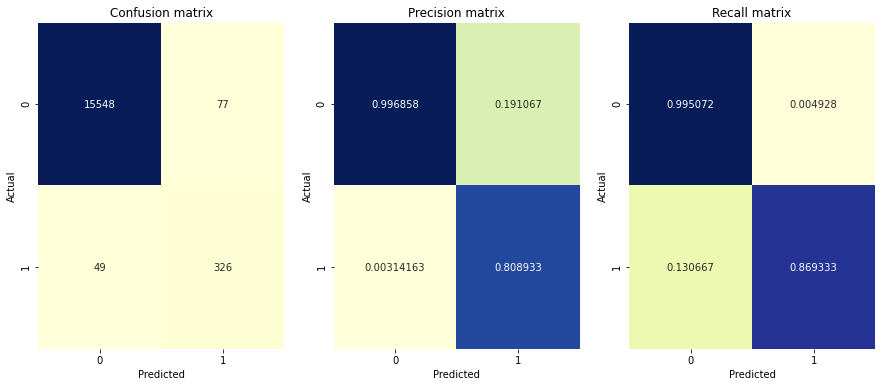

Misclassification Cost: 25270 	F-1 Score: 0.917005328290858


In [51]:
final2(X, Y)

# Deployment Functions and Link
To view the working webapp video on youtube, click [here](https://www.youtube.com/watch?v=1c4cG-wCkac&ab_channel=AmanSavaria)

To go to the webapp, click [here](http://ec2-3-133-82-84.us-east-2.compute.amazonaws.com:8501/)

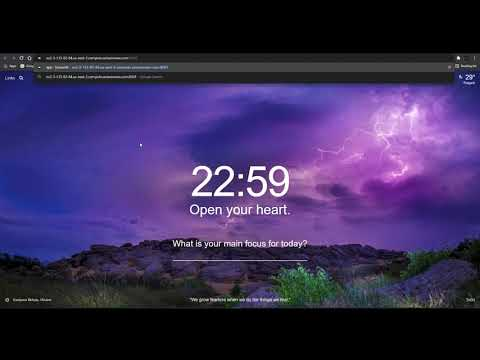

In [18]:
# Deployment video link
from IPython.display import YouTubeVideo
YouTubeVideo('1c4cG-wCkac', width=800, height=400)

### Code for deployment on AWS
_Note:_ For deployment, the median impuatation technique was used.

#### 1. Code for the streamlit webapp

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
from io import BytesIO, StringIO
import base64
from model_functions import predict
from metric_functions import misclassification_score
from datetime import datetime
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


##### utility functions #####
############ DOWNLOAD THE CSV WITH PREDICTIONS #################
# http://awesome-streamlit.org/
# https://discuss.streamlit.io/t/file-download-workaround-added-to-awesome-streamlit-org/1244

def download_csv(data):
    csv = data.to_csv(index=False)
    b64 = base64.b64encode(csv.encode()).decode()
    href = f'<a href="data:file/csv;base64,{b64}">Download CSV File</a> (right-click and save as &lt;some_name&gt;.csv)'
    return href

############# DISPLAY BUTTON TYPE #################\
def display_button(operation_type='Prediction'):
    '''
        This function displays the button based on the operation mode of the model.
    '''
    if operation_type=='Prediction':
        button_name = 'Make Prediction(s)'
    else:
        button_name = 'Start Evaluation'
    # display the button
    button = st.button(button_name)
    return button

#### UPLOAD THE CSV FILE CONTAINING THE DATAPOINTS ####
# https://www.youtube.com/watch?v=Uh_2F6ENjHs&ab_channel=soumilshah1995
def uploader():
    '''
        Function for uploading of the csv file containing the datapoints.
    '''
    upload = st.file_uploader('', type=['csv'])
    return upload

#### SHOW THE CONFUSION, PRECISION AND RECALL MATRICES ON THE STREAMLIT APP ####
def calculate_matrices(y_true, y_pred):
    '''
        This function calculates the elements of the confusion, precision and recall matrices.
    '''
    # confusion matrix
    confusion = confusion_matrix(y_true, y_pred)
    # precision matrix - column sum of confusion matrix
    precision = confusion/confusion.sum(axis=0)
    # recall matrix - row sum of confusion matrix
    recall = (confusion.T/confusion.sum(axis=1)).T

    return (confusion, precision, recall)

def show_matrix(y_true, y_pred, matrix='Confusion'):
    '''
        This function plots the confusion, precision and recall matrices in the streamlit
        webapp.
    '''
    sns.set_style('dark')
    fig, ax = plt.subplots(figsize=(6,6))
    # get the matrices
    confusion, precision, recall = calculate_matrices(y_true, y_pred)
    if matrix == 'Confusion':
        hmap = sns.heatmap(confusion, cbar=False, annot=True, cmap="YlGnBu", fmt='g', ax=ax)
    elif matrix == 'Precision':
        hmap = sns.heatmap(precision, cbar=False, annot=True, cmap="YlGnBu", fmt='.3g', ax=ax)
    elif matrix == 'Recall':
        hmap = sns.heatmap(recall, annot=True, cbar=False, cmap="YlGnBu", fmt='.3g', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
    return fig

###############################################################################################################################################
                                        # ACTUAL STREAMLIT PAGE #
###############################################################################################################################################

st.set_page_config(layout='wide') # set layout wide by default

# title
# set header font size in streamlit - https://discuss.streamlit.io/t/change-font-size-in-st-write/7606
st.markdown("""
<style>
.big-font {
    font-size:50px !important;
    font-family: georgia;
}
</style>
""", unsafe_allow_html=True)

st.markdown('<p class="big-font">Scania APS Fault Prediction</p>', unsafe_allow_html=True)

# image
st.image('https://c4.wallpaperflare.com/wallpaper/678/895/709/2016-crown-r520-scania-wallpaper-preview.jpg',
        caption='Source: https://c4.wallpaperflare.com/wallpaper/678/895/709/2016-crown-r520-scania-wallpaper-preview.jpg',
        width=1000)

# introduction
st.markdown("""
            The _ APS _ (Air Pressure System) of a heavy haul truck is a crucial part of any
            heavy haul truck which needs to be functioning propely at all times to ensure the
            smooth operation of any truck. The APS of a truck provides the required air pressure
            in the brakes of the truck for them to be disengaged. This pressure needs to be consistently
            provided to the brake shoes of all the wheels of the trucks. If any components of the APS 
            has any problem in it, this air pressure gets compromised which leads to the brackes being
            immediately engaged which causes the truck to immediately come to a stop and making it unable to
            move untill the pressure required is again introduced to the brakes. This makes the proper functioning
            of the APS all the more important.<br>
            This is why, a machine learning model has been developed and deployed to predict whether a problem
            in the truck corresponds to the APS or to any other part/mechanism of the truck.
""", unsafe_allow_html=True)

st.markdown('''<hr>''', unsafe_allow_html=True)

# modelling and prediction
# 3 modes - 
#       1. Multiple datapoints - take i/p file loc and o/p file location and save o/p file
#       2. Single datapoint - TODO - maybe take i/p file location and display class label
#       3. Preformance metrics - Take i/p file, predict and calculate performance metrics and display

st.header('''** MODELLING ** ''')

st.markdown('''There are 2 different operation modes.<br>
            1. **Predictions:-** Make predictions for datapoints.
            For this, the user needs to upload a csv file which containing all the datapoints 
            and all the default features. The model will then predict the labels for all the datapoints
            and will write them on a csv file which can be downloaded by the user.<br>
            2. **Performance Evaluation:-** The user will upload a csv file with already present class labels
            and the model after making predictions will calculate and print performance metrics on the screen.
            The metrics that will be printed are as follows:
            
                a. Confusion, Precision and Recall matrices.
                b. Macro-averaged F1 score
                c. Misclassification cost: 
                    Formula:- 10*FP + 500*FN
''', unsafe_allow_html=True)

# select box for mode selection
operation = st.radio('Operation mode:',
    options=('Prediction', 'Peformance evaluation'),
    index=0
)

################ UPLOADING THE REQUIRED DATAFRAME AND GIVE COMMAND FOR MAKING PREDICTIONS ###############
# Appropriate headers and displays based on the operation mode
if operation=='Prediction':
    st.header('Making Predictions')
    st.markdown('''
    Please upload the csv file containing the datapoints for which the prediction is to be made.
    ''')
    st.markdown('NOTE: If there are less than or equal to 10 rows in the csv file, then the predictions will be displayed on the screen along with the features. Else, a csv file link will be generated that the user will have to download to look at the results. The file will contain the class labels for each datapoint.')

    # show the upload area
    upload = uploader()
    # reading the csv and showing the top row
    if upload:
        csv = pd.read_csv(upload, na_values='na')
        st.markdown('Top few rows of the dataframe...')
        st.dataframe(csv.head())
        button = display_button()

elif operation=='Peformance evaluation':
    st.markdown('''
        <h2>Performance Evaluation of the model.</h2>
        ''', unsafe_allow_html=True)
    st.markdown('''
        Please upload the csv file containing the datpoints and the actual class labels for 
        evaluation of the model performance.
    ''')
    
    # showing the upload dialogue
    upload = uploader()
    # reading the csv and showing the csv file
    if upload:
        csv = pd.read_csv(upload, na_values='na')
        Y = csv['class']
        st.markdown('''Top few rows of the dataframe...''')
        st.dataframe(csv.head())

        # showing the button after the upload is completed
        button = display_button('Evaluation')


###################### MAKE PREDICTIONS OR EVALUATE PERFORMANCE BASED ON THE OPERATION MODE ##############
if upload and button: # if any file has been uploaded and the button has been pressed
    if operation=='Prediction':
        # we need to predict and show the results or add to a csv file and the user will download it.
        # making the predictions
        start = datetime.now()
        predictions = predict(csv)
        print('Time required:', datetime.now()-start)
        # now, if there are less than or equal to 10 datapoints, we are going to display the dataframe on the screen
        if predictions.shape[0] <= 10:
            st.dataframe(predictions)
            # href = download_csv(predictions)
            # st.markdown(href, unsafe_allow_html=True)
        else: # if there are more rows, then generate a link to download the csv file.
            href = download_csv(predictions['class'])
            st.markdown(href, unsafe_allow_html=True)
            # st.dataframe(predictions.head(100))
    if operation=='Peformance evaluation':
        st.markdown('''
            <h2> Model Performance metrics:
        ''', unsafe_allow_html=True)
        # we need to make predictions and display the scores
        predictions = predict(csv)['class']
        # misclassification score
        ms = misclassification_score(Y, predictions)
        # f1 score
        f1 = f1_score(Y, predictions, average='macro')
        # matrices
        st.markdown('''
            <h3>Confusion, Precision and Recall matrices...
        ''', unsafe_allow_html=True)
        conf = show_matrix(Y, predictions)
        pre = show_matrix(Y, predictions, 'Precision')
        re = show_matrix(Y, predictions, "Recall")

        # making columns and plotting heatmaps
        col1, col2, col3 = st.beta_columns(3)
        col1.header("Confusion Matrix")
        col1.pyplot(conf)
        col2.header("Precision Matrix")
        col2.pyplot(pre)
        col3.header('Recall Matrix')
        col3.pyplot(re)

        # displaying f1 score and misclassification cost
        col1, col2 = st.beta_columns(2)
        col1.header("Macro - F1 Score")
        col1.write(round(f1, 3))
        col2.header('Misclassification Cost')
        col2.write(ms)

#### 2. Code for the predict function

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from metric_functions import misclassification_score, plot_matrices
from datetime import datetime
import joblib
import streamlit as st

def predict(X):
    '''
        This function takes one or more datapoints, and predicts their class labels and 
        appends them to the dataframe itself
    '''
    if 'class' in X.columns:
        X.drop(columns='class', inplace=True) # dropping the class labels
    print(X.shape)

    # loading the imputation models and the imputation strategy list
    strat_list = joblib.load('Objects/strat_list.pickle')
    imputer = joblib.load("Objects/simpleImputer.pkl")

    # performing missing value imputation
    # dropping the features with high missing values
    inter_ = X.drop(columns=strat_list[3])
    inter_ = inter_.drop(columns=['cd_000'])

    # mice imputation
    data = pd.DataFrame(imputer.transform(inter_), columns=inter_.columns)


    # scaling the data
    # loading the min max scaler object
    normalizer = joblib.load('Objects/minmaxScaler.pkl')
    # normalizing the values 
    data_norm = normalizer.transform(data)

    # loading the model and the optimal threshold and predicting
    predictors = joblib.load('Objects/xgb_clf_49_77.pkl')
    model = predictors['model']
    threshold = predictors['threshold']

    # making the predictions
    # getting probabilities
    probas = model.predict_proba(data_norm)[:,1]

    # making predictions
    preds = ['pos' if p>0.2 else 'neg' for p in probas]
    data['class'] = preds

    return data